In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.2  Device :  cuda


오디오들이 
1초, 2초, 3초 각각 다르다.

음성이 뭉개진 데이터도 있다.

# 추출해야하는 feature

- time-frequency : 13 MFCC  
- pitch, rolloff, ZCR, energy entropy, spectral flux,  spectral centroid, energy

### 오디오 전처리

https://hyunlee103.tistory.com/36

https://hyongdoc.tistory.com/404

https://ichi.pro/ko/python-eul-sayonghan-eum-ag-jangleu-bunlyu-218892206272728

https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/ : librosa 설명

torchaudio

https://ahnjg.tistory.com/93

https://medium.com/analytics-vidhya/how-to-classify-sounds-using-pytorch-27c9f2d4d714 :mfcc

https://www.youtube.com/watch?v=rlypsap6Wow&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=8

https://www.youtube.com/watch?v=oltGIc4uo5c&t=5132s 피처들


torchaudio를 사용해 음성을 읽으면 음성 데이터와 sampling rate를 반환.

sampling rate : 1초당 들리는 sample의 개수 (1초를 더 쪼갠것)

데이터 길이 / sampling rate = 음성 파일의 시간

In [7]:
!pip install torchaudio

------

In [8]:
!pip install librosa --user

In [12]:
#!pip install numba==0.53# numpy 버전 맞추기 위해서

  Using cached numba-0.53.0-cp38-cp38-win_amd64.whl (2.3 MB)
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'D:\\miniconda3\\envs\\local_torch\\Lib\\site-packages\\~umba\\core\\runtime\\_nrt_python.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
import numpy as np
np.__version__

'1.21.5'

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)
sr=50000

#audio_path = './voice_data/disorder/export/blues.00000.wav'
#audio_path = './voice_data/disorder/export/105-phrase.wav'
audio_path = './voice_data/fusion/pathology/phrase/105-phrase.wav'
sig, sr = librosa.load(audio_path, sr=sr)# 논문에서 f_s = 50 000HZ
length=318596
#pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
#sig = pad1d(sig,length)  

#모음데이터는 1초에서 3초로 sampling 했다고 한다. (2초)

print(sig.shape,sr)
print(sig.shape[0]/sr)
sr_time=sig.shape[0]/sr
#155269 sample임을 알 수 있고
#sampling frame이 50000이다.
#시간 : 155269/50000

#음성 파일마다 sample수가 달라서, cnn은 통일해야한다.
#통일안하면, mfcc frame수도 달라진다.

(174653,) 50000
3.49306


In [6]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

#audio_path = './voice_data/disorder/export/blues.00000.wav'
#audio_path = './voice_data/disorder/export/105-phrase.wav'
audio_path = './voice_data/fusion/pathology/a/107-a_n.wav'
sig_healthy, sr_sig_healthy = librosa.load(audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
length=318596
sig = pad1d(sig_healthy,length)  


#모음데이터는 1초에서 3초로 sampling 했다고 한다. (2초)

print(sig.shape,sr)
print(sig.shape[0]/sr)
sr_time_sig_healthy=sig.shape[0]/sr
print(sr_time_sig_healthy)
#155269 sample임을 알 수 있고
#sampling frame이 50000이다.
#시간 : 155269/50000

#음성 파일마다 sample수가 달라서, cnn은 통일해야한다.
#통일안하면, mfcc frame수도 달라진다.

NameError: name 'pad1d' is not defined

In [7]:
healthy_audios = []
disorder_audios = []

healthy_audios.append('./voice_data/fusion/healthy/phrase/1-phrase.wav')
healthy_audios.append('./voice_data/fusion/healthy/phrase/2-phrase.wav')
healthy_audios.append('./voice_data/fusion/healthy/phrase/3-phrase.wav')

disorder_audios.append('./voice_data/fusion/pathology/phrase/108-phrase.wav')
disorder_audios.append('./voice_data/fusion/pathology/phrase/109-phrase.wav')
disorder_audios.append('./voice_data/fusion/pathology/phrase/110-phrase.wav')


healthy_audios =[ librosa.load(aud, sr=50000)[0] for aud in healthy_audios ]
disorder_audios =[ librosa.load(aud, sr=50000)[0] for aud in disorder_audios ]



Text(0.5, 1.0, 'Waveform')

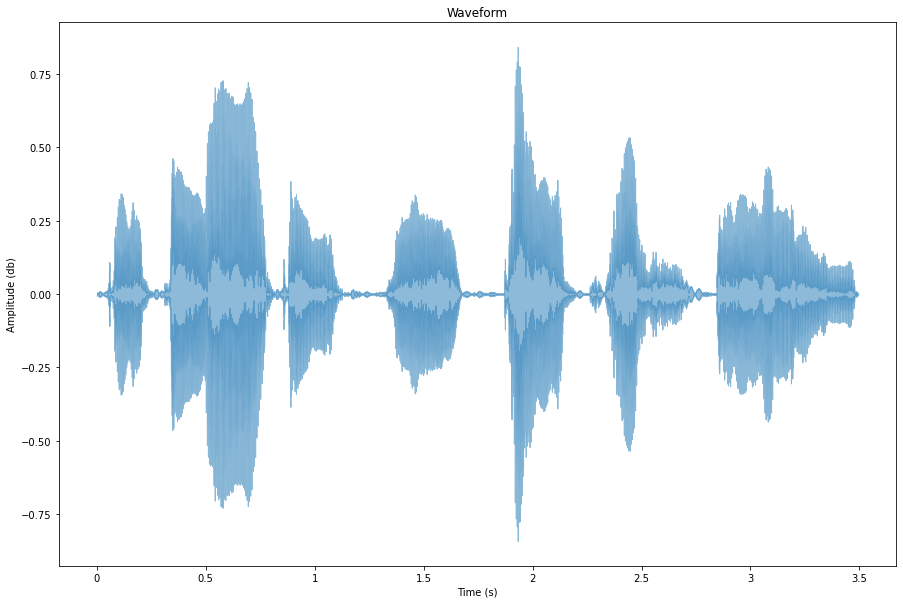

In [8]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sig, sr=sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (db)")
plt.title("Waveform")

In [ ]:
https://newsight.tistory.com/294

## 단순 푸리에 변환 → Spectrum

Text(0.5, 1.0, 'Power spectrum')

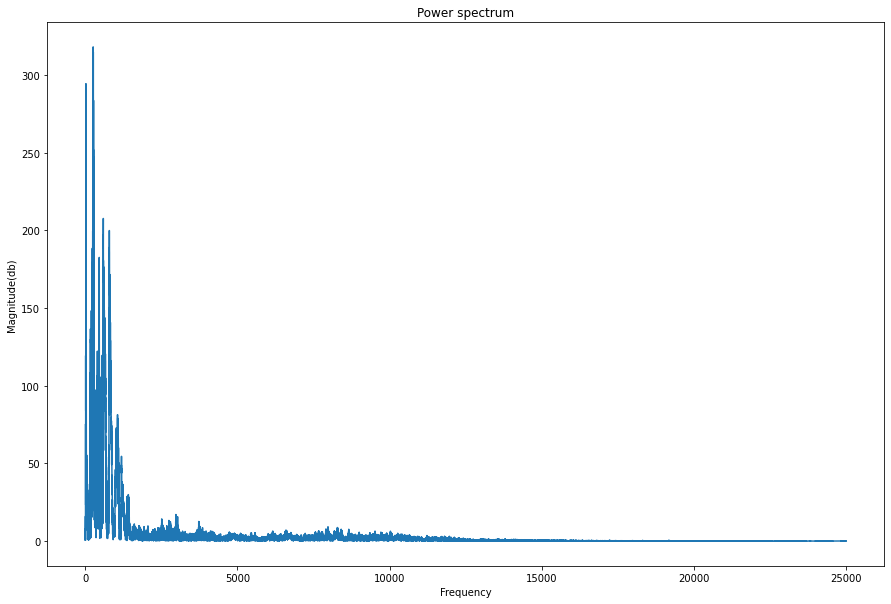

In [19]:
fft = np.fft.fft(healthy_audios[0])

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
#left_spectrum = magnitude
#left_f=f
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude(db)")
plt.title("Power spectrum")

In [ ]:
fft = np.fft.fft(sig)

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
#left_spectrum = magnitude
#left_f=f
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude(db)")
plt.title("Power spectrum")

In [17]:
sig.shape[0]

155269

In [18]:
np.int64(np.ceil(1250/4))

313

# STFT

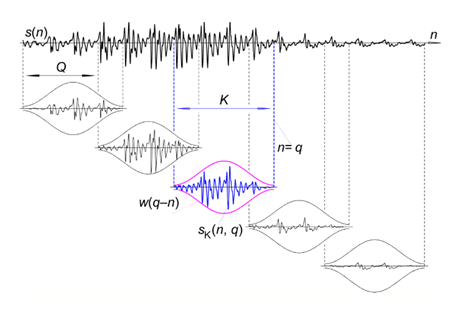

- https://sanghyu.tistory.com/38?category=1120070

In [3]:
stfts=librosa.stft(sig,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
print(len(stfts[0]))

NameError: name 'win_length' is not defined

# MFCC

- window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
- 자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
- 초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
- nfft : WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
- hop_length : 얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4 또는 10ms만큼으로 한다고 한다. hop_length가 mfcc의 frame수를 결정한다.


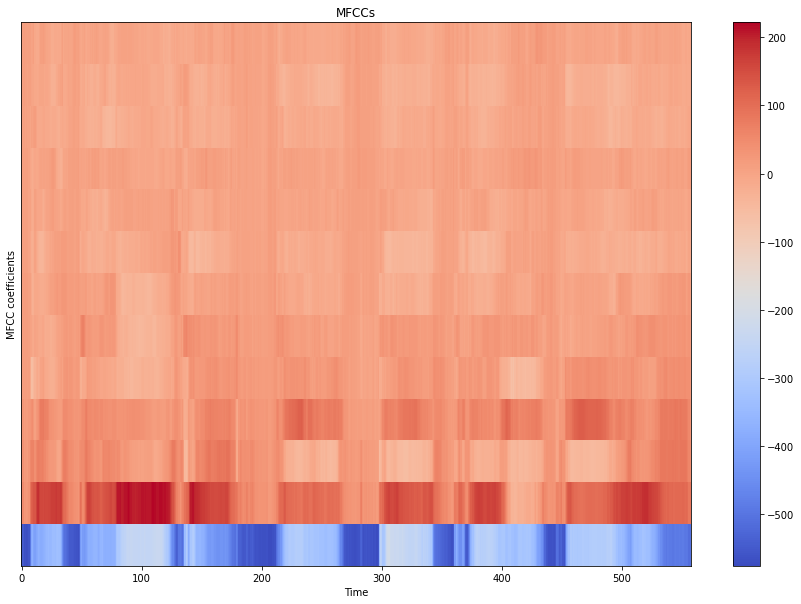

(13, 558)


In [5]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다. (stride)
#hop: 윈도우가 겹치는 사이즈

#hop_length가 mfcc의 frame수를 결정한다.


MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
#MFCCs=cv2.resize(MFCCs,(224,224),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 300 사이즈로
#scaler.fit(MFCCs)
#MFCCs=scaler.transform(MFCCs)

#length=300

#pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
#MFCCs = pad2d(MFCCs, length)


# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

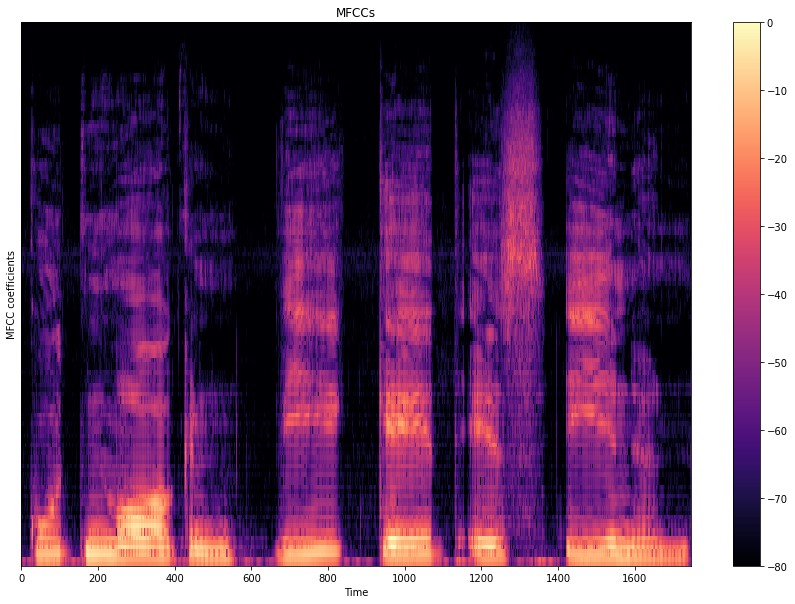

(13, 558)


In [26]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

win_length =  np.int64(16000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다. (stride)
#hop: 윈도우가 겹치는 사이즈

#hop_length가 mfcc의 frame수를 결정한다.


mel = librosa.feature.melspectrogram(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

Text(0.5, 0, 'Time')

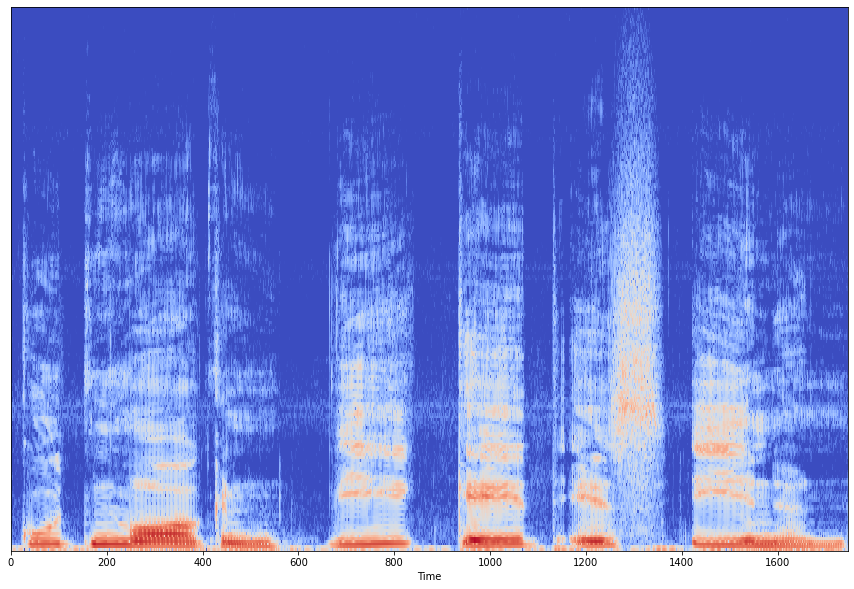

In [27]:
sr=16000
win_length =  np.int64(16000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4

stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

Text(0.5, 0, 'Time')

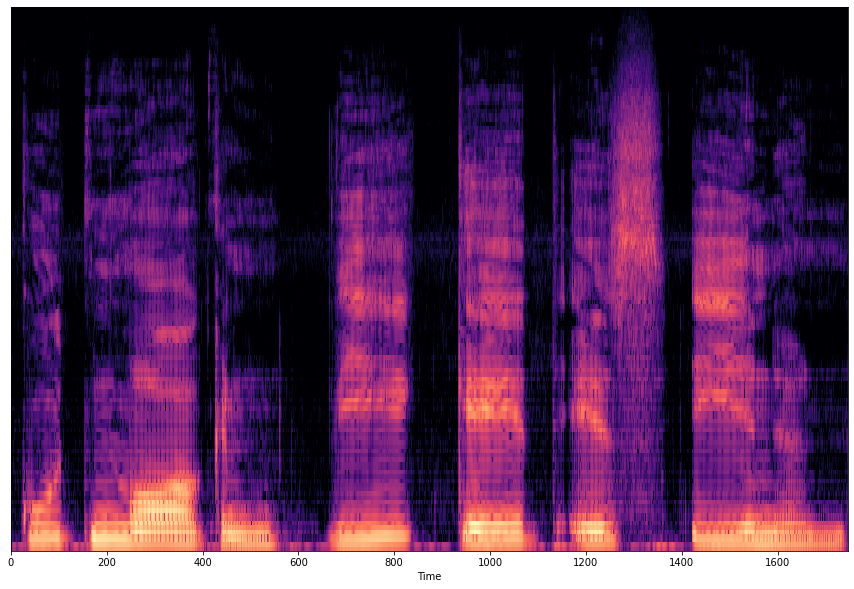

In [28]:
# stft -> mel-spectro 가능.
# log spectro -> mel-spectro 가능한가? ( db_to_amplitude + **2 을 통해 power spectrum을 만들어준다.)
# mel spectro -> mfcc 가능.


sr=16000
win_length =  np.int64(16000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4


stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

power_spectro = librosa.db_to_amplitude(log_spectrogram)**2


#D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=power_spectro, sr=sr)
S = librosa.core.power_to_db(S,ref=np.max)


plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(S, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

In [55]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.

win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다. (stride)
#hop: 윈도우가 겹치는 사이즈

#hop_length가 mfcc의 frame수를 결정한다.


MFCCs = librosa.feature.mfcc(sig_healthy, sr_sig_healthy,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

TypeError: mfcc() takes 0 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

# STFT

### MFCC 497 frame을 시간으로 다시 변환

 round( sample수 / hop_length )= 497 frame
 
 497frame * hop_length = sample 수


In [35]:
np.ceil(155269/313)

497.0

In [40]:
497*313

155561

497 frame (50,000 sr) ->  3.1초


MFCC 500 frame을 기준으로 길이 고정.

In [41]:
500*313

156500

In [16]:
np.ceil(156200/313)

500.0

## 시간을 기준으로 자르기

sample_rate * 시간


In [7]:
50000 * 2.5

125000.0

In [6]:
np.ceil(125000/313)

400.0

# 제로 크로싱

In [4]:
zero_crossing = librosa.zero_crossings()

TypeError: zero_crossings() missing 1 required positional argument: 'y'

# 스펙트로그램

Text(0.5, 1.0, 'Spectrogram (dB)')

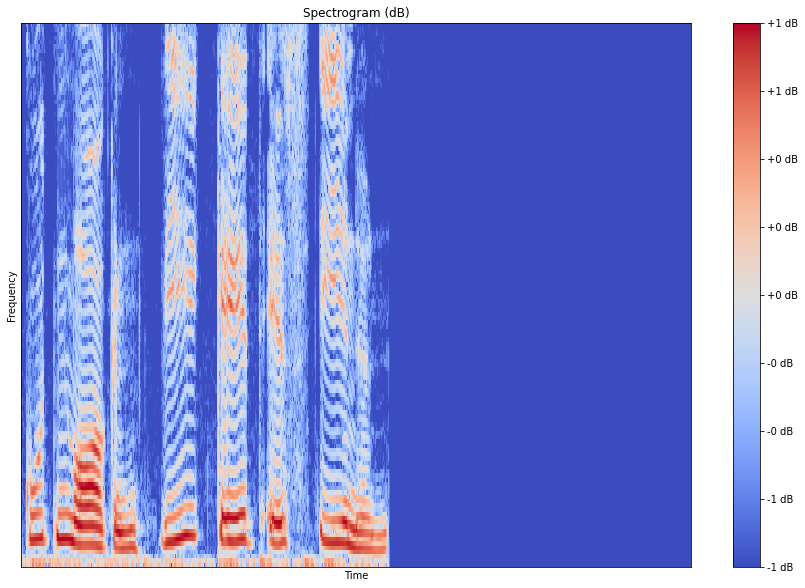

In [9]:
stfts=librosa.stft(sig,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=FIG_SIZE)
magnitude = np.abs(stfts)
log_spectrogram = librosa.amplitude_to_db(magnitude)
log_spectrogram=librosa.util.normalize(log_spectrogram) # l-infinity norm

log_spectrogram = log_spectrogram[:128,:]


librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)




plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [14]:
print(stfts.shape)

(626, 497)


Text(0.5, 1.0, 'Spectrogram (dB)')

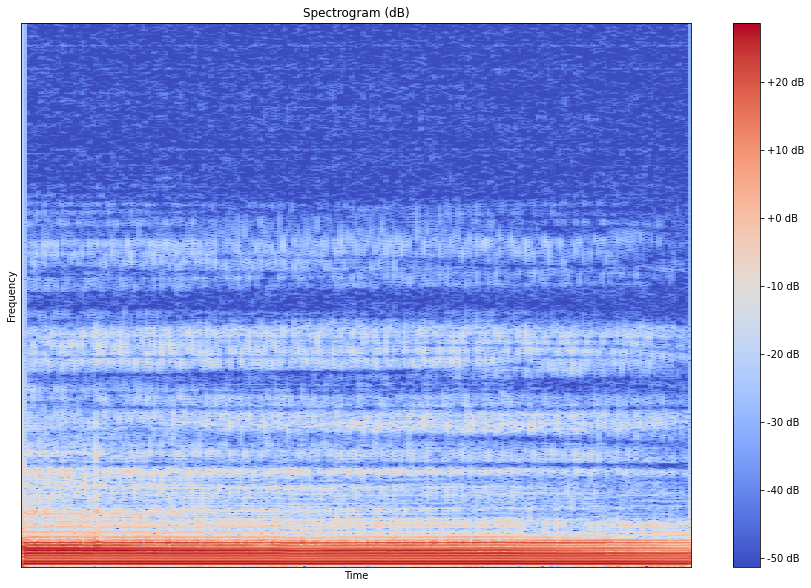

In [10]:
#healthy
stfts=librosa.stft(sig_healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=FIG_SIZE)
magnitude = np.abs(stfts)
log_spectrogram = librosa.amplitude_to_db(magnitude)
librosa.display.specshow(log_spectrogram, sr=sr_sig_healthy, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Spectrogram (dB)')

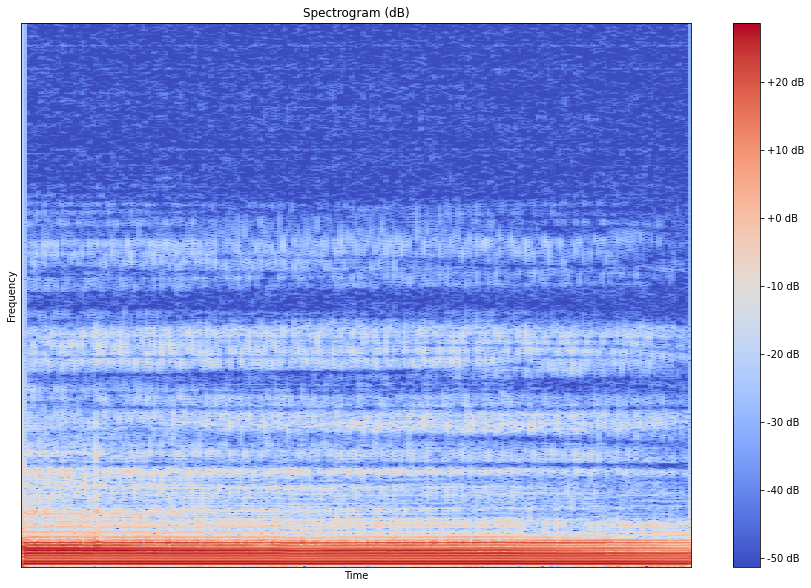

In [11]:
#healthy
stfts=librosa.stft(sig_healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length)
plt.figure(figsize=FIG_SIZE)
magnitude = np.abs(stfts)
log_spectrogram = librosa.amplitude_to_db(magnitude)
librosa.display.specshow(log_spectrogram, sr=sr_sig_healthy, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [22]:
print(stfts.shape)

(626, 328)


<Figure size 1080x720 with 0 Axes>

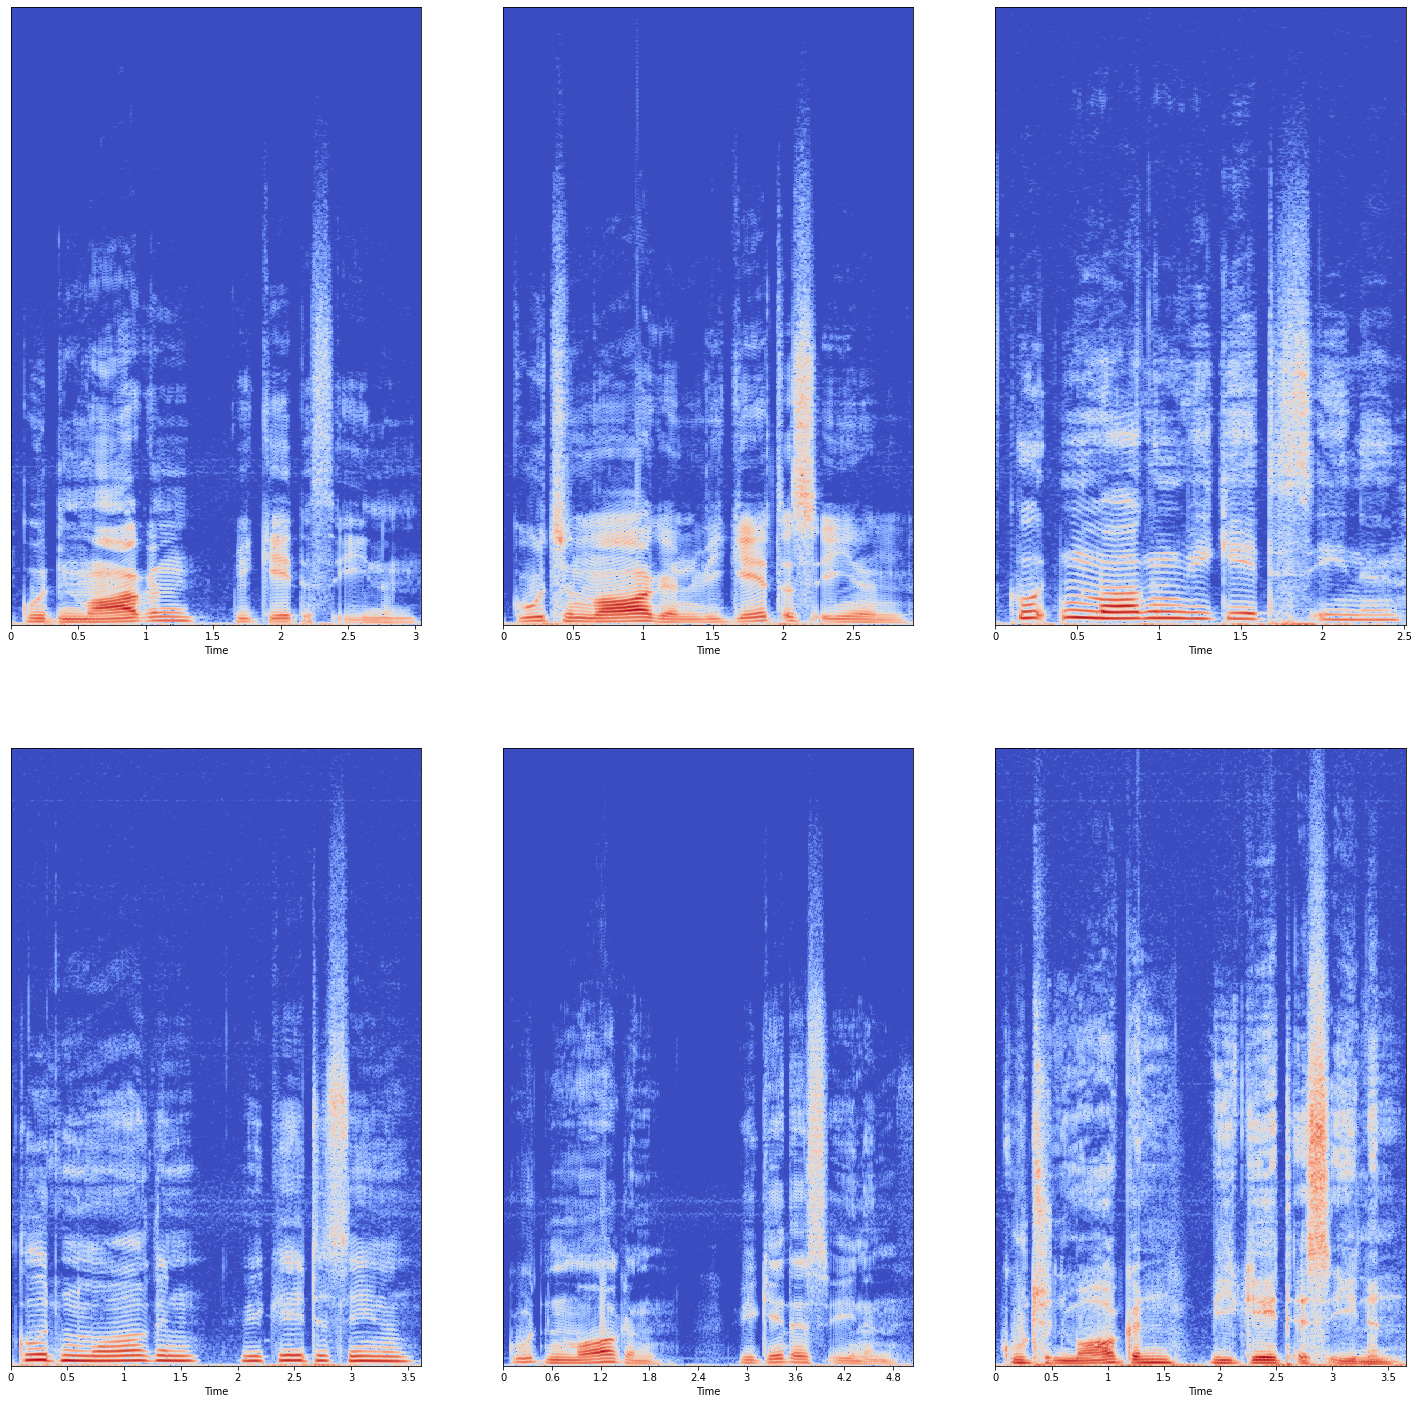

In [16]:
fig = plt.figure(figsize=(15,10))

stfts_healthy=[librosa.stft(healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length) for healthy in healthy_audios ]
stfts_disorder=[librosa.stft(healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length) for healthy in disorder_audios ]


stfts_healthy = [ librosa.amplitude_to_db(np.abs(healthy)) for healthy in stfts_healthy ]
stfts_disorder = [ librosa.amplitude_to_db(np.abs(healthy)) for healthy in stfts_disorder ]

plt.figure(figsize=(25,25))


plt.subplot(231)
librosa.display.specshow(stfts_healthy[0], sr=50000, x_axis='time',y_axis)
plt.subplot(232)
librosa.display.specshow(stfts_healthy[1], sr=50000, x_axis='time')
plt.subplot(233)
librosa.display.specshow(stfts_healthy[2], sr=50000, x_axis='time')

plt.subplot(234)
librosa.display.specshow(stfts_disorder[0], sr=50000, x_axis='time')
plt.subplot(235)
librosa.display.specshow(stfts_disorder[1], sr=50000, x_axis='time')
plt.subplot(236)
librosa.display.specshow(stfts_disorder[2], sr=50000, x_axis='time')

# 멜 스펙트로그램

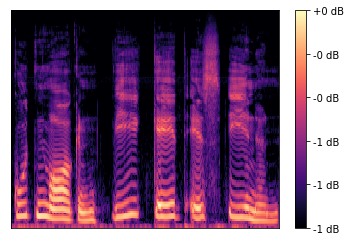

In [17]:
mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

librosa.display.specshow(mel_feature, sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')


In [ ]:
np.resize(mel_feature,)

(128, 328)


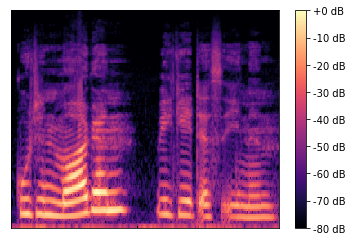

In [29]:
mel_feature = librosa.feature.melspectrogram(sig_healthy,sr=sr_sig_healthy,hop_length=hop_length,n_fft=n_fft)
print(mel_feature.shape)
mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
librosa.display.specshow(mel_feature, sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')


<Figure size 1080x720 with 0 Axes>

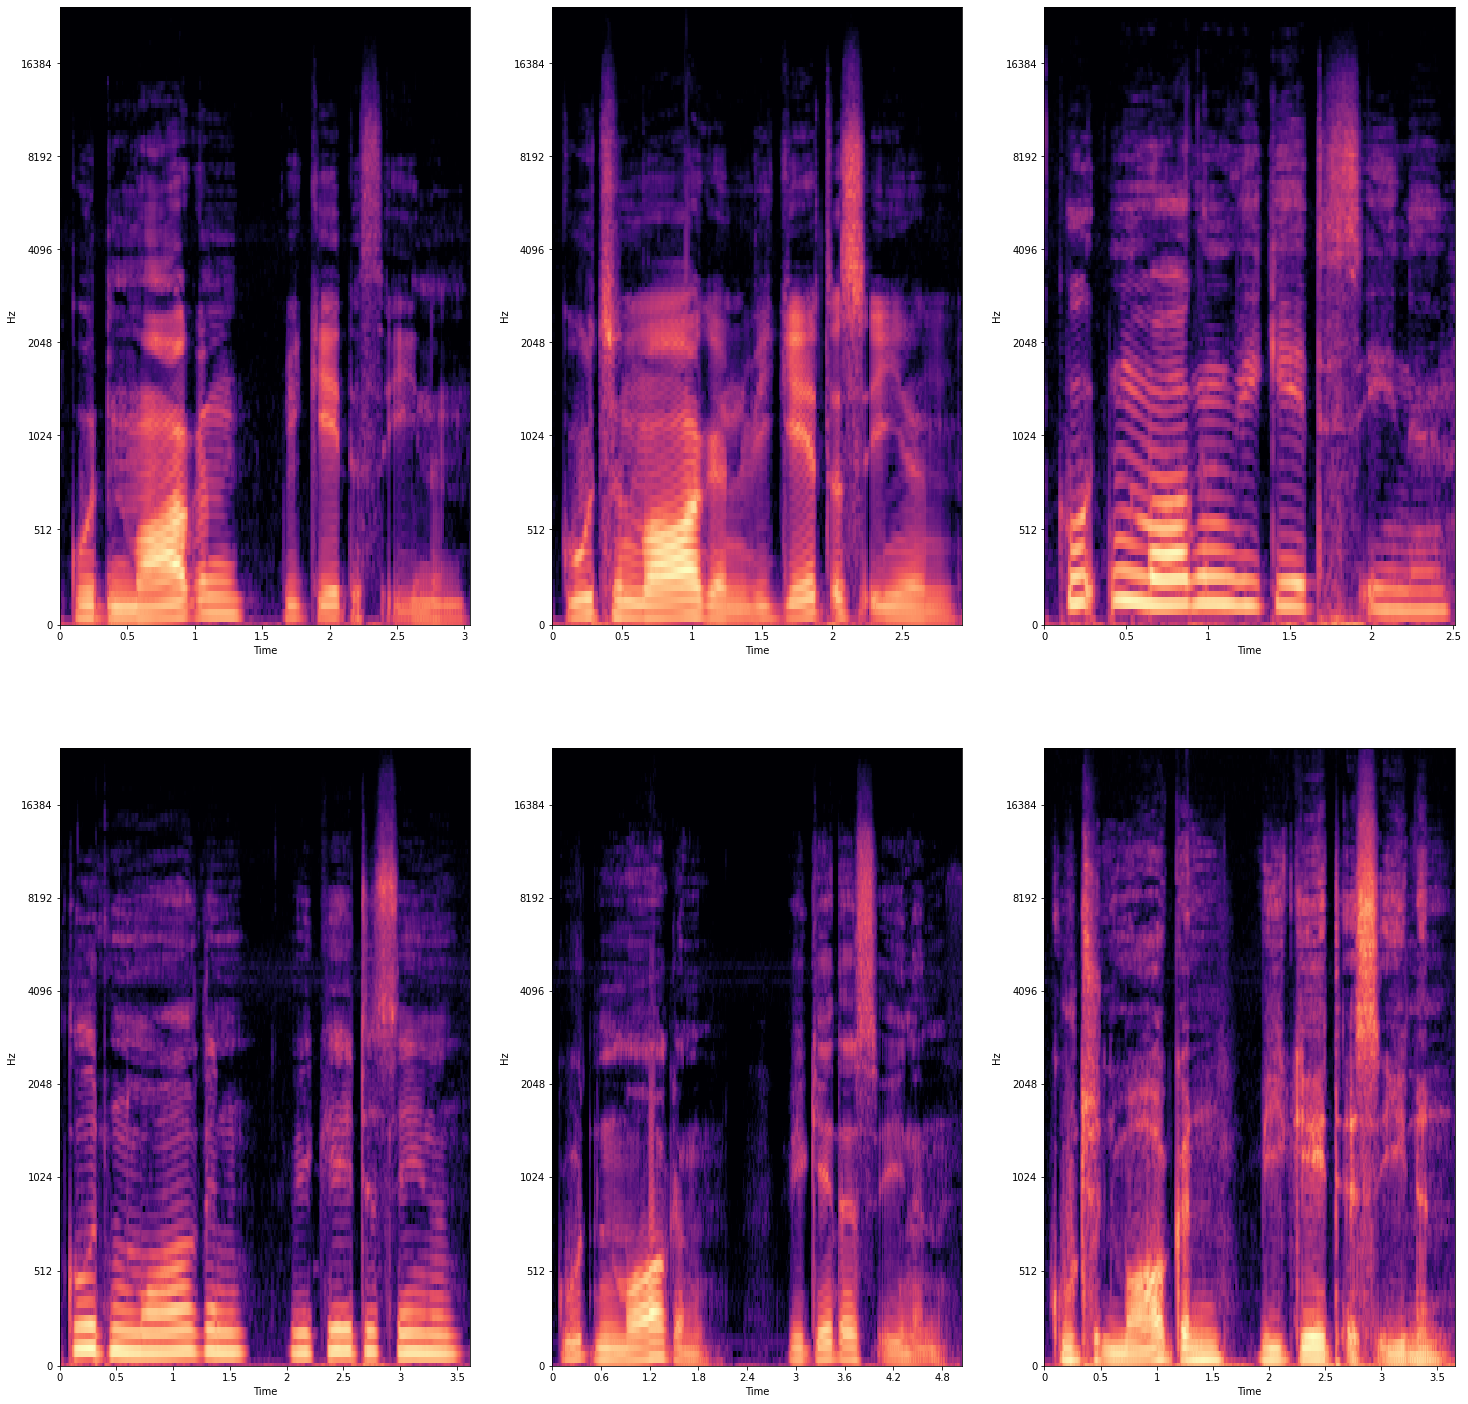

In [30]:
fig = plt.figure(figsize=(15,10))

mel_healthy=[librosa.feature.melspectrogram(healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length) for healthy in healthy_audios ]
mel_disorder=[librosa.feature.melspectrogram(healthy,win_length=win_length,n_fft=n_fft, hop_length=hop_length) for healthy in disorder_audios ]


mel_healthy = [ librosa.core.power_to_db(healthy,ref=np.max) for healthy in mel_healthy ]
mel_disorder = [ librosa.core.power_to_db(healthy,ref=np.max) for healthy in mel_disorder ]

plt.figure(figsize=(25,25))


plt.subplot(231)
librosa.display.specshow(mel_healthy[0], sr=50000, x_axis='time',y_axis='mel')
plt.subplot(232)
librosa.display.specshow(mel_healthy[1], sr=50000, x_axis='time',y_axis='mel')
plt.subplot(233)
librosa.display.specshow(mel_healthy[2], sr=50000, x_axis='time',y_axis='mel')

plt.subplot(234)
librosa.display.specshow(mel_disorder[0], sr=50000, x_axis='time',y_axis='mel')
plt.subplot(235)
librosa.display.specshow(mel_disorder[1], sr=50000, x_axis='time',y_axis='mel')
plt.subplot(236)
librosa.display.specshow(mel_disorder[2], sr=50000, x_axis='time',y_axis='mel')

# 평균,std 계산

In [19]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('./voice_data/fusion/pathology/phrase/*.wav')
healthy = glob('./voice_data/fusion/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1193:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1193
Healthy:  634
총 데이터수 :  1827
---
훈련 셋 :  1461 Counter({'pathology': 954, 'healthy': 507})
테스트 셋 :  366 Counter({'pathology': 239, 'healthy': 127})
---


In [15]:
value[0].mean(axis=(0,1))

-17.94339751622128

In [23]:


spectro_mean=[]
spectro_std=[]

mel_mean=[]
mel_std=[]

mfcc_mean=[]
mfcc_std=[]


for key,value in phrase_dict.items():
    #print(value[0])
    spectro_mean.append(np.mean(value[0],axis=(0,1))) # spectrogram
    spectro_std.append(np.std(value[0],axis=(0,1))) # spectrogram
    
for key,value in phrase_dict.items():
    #print(value[0])
    mel_mean.append(np.mean(value[1],axis=(0,1))) # spectrogram
    mel_std.append(np.std(value[1],axis=(0,1))) # spectrogram
    
for key,value in phrase_dict.items():
    #print(value[0])
    mfcc_mean.append(np.mean(value[2],axis=(0,1))) # spectrogram
    mfcc_std.append(np.std(value[2],axis=(0,1))) # spectrogram    

    
    

print('spectro mean, std : ',np.mean(spectro_mean),np.mean(spectro_std))
print('mel mean, std : ',np.mean(mel_mean),np.mean(mel_std))
print('mfcc mean, std : ',np.mean(mfcc_mean),np.mean(mfcc_std))

spectro mean, std :  -16.959403728800456 16.64427103102976
mel mean, std :  -56.42725867474826 20.599962627986784
mfcc mean, std :  -1.3719194475902463 39.00836539118236


In [25]:
spectro_mean=[]
spectro_std=[]

mel_mean=[]
mel_std=[]

mfcc_mean=[]
mfcc_std=[]


for key,value in a_dict.items():
    #print(value[0])
    spectro_mean.append(np.mean(value[0],axis=(0,1))) # spectrogram
    spectro_std.append(np.std(value[0],axis=(0,1))) # spectrogram
    
for key,value in a_dict.items():
    #print(value[0])
    mel_mean.append(np.mean(value[1],axis=(0,1))) # spectrogram
    mel_std.append(np.std(value[1],axis=(0,1))) # spectrogram
    
for key,value in a_dict.items():
    #print(value[0])
    mfcc_mean.append(np.mean(value[2],axis=(0,1))) # spectrogram
    mfcc_std.append(np.std(value[2],axis=(0,1))) # spectrogram 
    
    
    
print('spectro mean, std : ',np.mean(spectro_mean),np.mean(spectro_std))
print('mel mean, std : ',np.mean(mel_mean),np.mean(mel_std))
print('mfcc mean, std : ',np.mean(mfcc_mean),np.mean(mfcc_std))

spectro mean, std :  -4.907324915174754 14.036443776920903
mel mean, std :  -30.498582651083968 25.28904171868132
mfcc mean, std :  -1.0402891308227304 26.997127175085947


# 데이터 피클 저장

In [5]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt


pathology = glob('./voice_data/fusion_new/pathology/phrase/*.wav')
healthy = glob('./voice_data/fusion_new/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1353:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1353
Healthy:  634
총 데이터수 :  1987
---
훈련 셋 :  1589 Counter({'pathology': 1082, 'healthy': 507})
테스트 셋 :  398 Counter({'pathology': 271, 'healthy': 127})
---


트레인셋 최대 길이 구하기.
phrase 데이터

In [ ]:
all_phrase = []
for path in X:
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    all_phrase.append(sig)
    
path_max=max([ len(samples) for samples in all_phrase])
print('phrase 데이터 최대길이',path_max)

a 데이터

In [46]:
all_a = []
for path in X:
    file_name = path.split("\\")[-1]
    kind = path.split('\\')[0].split('/')[3]
    path = "./voice_data/fusion/"+kind+'/a/'+file_name.split('-')[0]+'-a_n.wav'
    sig, sr = librosa.load(path, sr=50000)# 논문에서 f_s = 50 000HZ
    all_a.append(sig)
    
path_max=max([ len(samples) for samples in all_a])
print('a 데이터 최대길이',path_max)

a 데이터 최대길이 219501


In [55]:
# min max sclaer
#train set에서만 min max scaler를 fit 시킨다.
from sklearn.preprocessing import MinMaxScaler




mel_list = []
spectro_list = []
mfcc_list = []


#train set들만 모음.
for path in X:
    sig, sr = librosa.load(path, sr=50000)# 논문에서 f_s = 50 000HZ
    #원본 시그널 패딩
    length = 318596
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)    
    
    
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    #length = 300
    
    
    spec_min=np.min(log_spectrogram)
    mel_feature_min=np.min(mel_feature)
    MFCCs_min=np.min(MFCCs)
    
    #pad2d = lambda a, i,min_data: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.full((a.shape[0], i-a.shape[1]),min_data)))
    #log_spectrogram = pad2d(log_spectrogram, length,spec_min)
    #mel_feature = pad2d(mel_feature, length,mel_feature_min)
    #MFCCs = pad2d(MFCCs, length,MFCCs_min)
    
    
    
    spectro_list.append(log_spectrogram)
    mel_list.append(mel_feature)
    mfcc_list.append(MFCCs)
    




In [56]:
scaler_MFCC = MinMaxScaler()
scaler_mel = MinMaxScaler()
scaler_spec = MinMaxScaler()


spectro_list=np.array(spectro_list)
mel_list=np.array(mel_list)
mfcc_list=np.array(mfcc_list)

num_data = 1461

for ss in range(num_data):
    scaler_spec.partial_fit(spectro_list[ss,:, :])
    
for ss in range(num_data):
    scaler_mel.partial_fit(mel_list[ss,:, :])
    
for ss in range(num_data):
    scaler_MFCC.partial_fit(mfcc_list[ss,:, :])
    

    
for ss in range(num_data):
    spectro_list[ss, :, :]=scaler_spec.transform(spectro_list[ss, :, :])
    
for ss in range(num_data):
    mel_list[ss, :, :]=scaler_mel.transform(mel_list[ss, :, :])
    
    
for ss in range(num_data):
    mfcc_list[ss, :, :]=scaler_MFCC.transform(mfcc_list[ss, :, :])

In [31]:
phrase_dict=dict()
a_dict=dict()

In [32]:
import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/fusion/pathology/phrase/*.wav')
healthy = glob('./voice_data/fusion/healthy/phrase/*.wav')


for path in pathology:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=50000)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 318596
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
    #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로


    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    #spec_min=np.min(log_spectrogram)
    #mel_feature_min=np.min(mel_feature)
    #MFCCs_min=np.min(MFCCs)
    
    #pad2d = lambda a, i,min_data: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.full((a.shape[0], i-a.shape[1]),min_data)))
    #log_spectrogram = pad2d(log_spectrogram, length,spec_min)
    #mel_feature = pad2d(mel_feature, length,mel_feature_min)
    #MFCCs = pad2d(MFCCs, length,MFCCs_min)
    
    
    #min max scale
    #log_spectrogram=scaler_spec.transform(log_spectrogram)
    #mel_feature=scaler_mel.transform(mel_feature)
    #MFCCs=scaler_MFCC.transform(MFCCs)
    
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    phrase_dict[file_name] = file_list


for path in healthy:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=50000)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 318596
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
    #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로


    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    #spec_min=np.min(log_spectrogram)
    #mel_feature_min=np.min(mel_feature)
    #MFCCs_min=np.min(MFCCs)
    
    #pad2d = lambda a, i,min_data: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.full((a.shape[0], i-a.shape[1]),min_data)))
    #log_spectrogram = pad2d(log_spectrogram, length,spec_min)
    #mel_feature = pad2d(mel_feature, length,mel_feature_min)
    #MFCCs = pad2d(MFCCs, length,MFCCs_min)
    
    
    #min max scale
    #log_spectrogram=scaler_spec.transform(log_spectrogram)
    #mel_feature=scaler_mel.transform(mel_feature)
    #MFCCs=scaler_MFCC.transform(MFCCs)
    
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    phrase_dict[file_name] = file_list


In [33]:


pathology = glob('./voice_data/fusion/pathology/a/*.wav')
healthy = glob('./voice_data/fusion/healthy/a/*.wav')


for path in pathology:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=50000)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 318596
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
    #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로


    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    spec_min=np.min(log_spectrogram)
    mel_feature_min=np.min(mel_feature)
    MFCCs_min=np.min(MFCCs)
    
    #pad2d = lambda a, i,min_data: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.full((a.shape[0], i-a.shape[1]),min_data)))
    #log_spectrogram = pad2d(log_spectrogram, length,spec_min)
    #mel_feature = pad2d(mel_feature, length,mel_feature_min)
    #MFCCs = pad2d(MFCCs, length,MFCCs_min)
    
    
    #min max scale
    #log_spectrogram=scaler_spec.transform(log_spectrogram)
    #mel_feature=scaler_mel.transform(mel_feature)
    #MFCCs=scaler_MFCC.transform(MFCCs)
    
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    a_dict[file_name] = file_list
    
    
for path in healthy:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=50000)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 318596
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
    #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로


    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    #spec_min=np.min(log_spectrogram)
    #mel_feature_min=np.min(mel_feature)
    #MFCCs_min=np.min(MFCCs)
    
    #pad2d = lambda a, i,min_data: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.full((a.shape[0], i-a.shape[1]),min_data)))
    #log_spectrogram = pad2d(log_spectrogram, length,spec_min)
    #mel_feature = pad2d(mel_feature, length,mel_feature_min)
    #MFCCs = pad2d(MFCCs, length,MFCCs_min)
    
    
    #min max scale
    #log_spectrogram=scaler_spec.transform(log_spectrogram)
    #mel_feature=scaler_mel.transform(mel_feature)
    #MFCCs=scaler_MFCC.transform(MFCCs)
    
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    a_dict[file_name] = file_list


In [34]:
import pickle

 
## Save pickle
with open("./voice_data/fusion/phrase_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("./voice_data/fusion/phrase_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

    
        
    
## Save pickle
with open("./voice_data/fusion/a_dict.pickle","wb") as fw:
    pickle.dump(a_dict, fw)
#load
with open("./voice_data/fusion/a_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)
    

In [6]:
import pickle

with open("./voice_data/fusion/phrase_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)
    
with open("./voice_data/fusion/a_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)

# ALL DATA 출력

In [2]:
# ALL DATA
#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('D:/project/voice_pathology_ai/voice_data/all_data/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/all_data/healthy/phrase/*.wav')

phrase_dict=dict()

for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig
    


In [3]:
import pickle
#원본 시그널

 
## Save pickle
with open("D:/project/voice_pathology_ai/voice_data/all_data/phrase_sig_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("D:/project/voice_pathology_ai/voice_data/all_data/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


In [4]:
# a발음 원본 시그널
a_dict = dict()


#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('D:/project/voice_pathology_ai/voice_data/all_data/pathology/a/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/all_data/pathology/a/*.wav')


for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig
    



In [5]:
import pickle
#원본 시그널

 
## Save pickle
with open("D:/project/voice_pathology_ai/voice_data/all_data/a_sig_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("D:/project/voice_pathology_ai/voice_data/all_data/a_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


# Fusion data 출력

In [3]:

#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/fusion_new/pathology/phrase/*.wav')
healthy = glob('./voice_data/fusion_new/healthy/phrase/*.wav')

phrase_dict=dict()

for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig
    


In [4]:
import pickle
#원본 시그널

 
## Save pickle
with open("./voice_data/fusion_new/phrase_sig_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("./voice_data/fusion_new/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


In [7]:
# a발음 원본 시그널
a_dict = dict()


#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/fusion_new/pathology/a/*.wav')
healthy = glob('./voice_data/fusion_new/healthy/a/*.wav')


for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig
    



In [8]:
import pickle
#원본 시그널

 
## Save pickle
with open("./voice_data/fusion_new/a_sig_dict.pickle","wb") as fw:
    pickle.dump(a_dict, fw)
#load
with open("./voice_data/fusion_new/a_sig_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)


# Organic data 출력

In [9]:

#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/organics/pathology/phrase/*.wav')
healthy = glob('./voice_data/organics/healthy/phrase/*.wav')

phrase_dict=dict()

for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig
    


In [13]:

#원본 시그널 출력하는 함수
#표준화 추가 


import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/organics/pathology/phrase/*.wav')
healthy = glob('./voice_data/organics/healthy/phrase/*.wav')

phrase_dict=dict()

for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    sig=(sig-np.mean(sig))/np.std(sig)
    
    phrase_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    sig=(sig-np.mean(sig))/np.std(sig)
    phrase_dict[file_name] = sig
    


KeyboardInterrupt: 

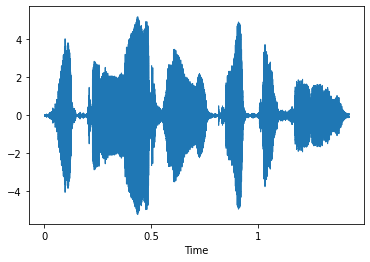

In [18]:
librosa.display.waveshow((sig-np.mean(sig))/np.std(sig))

In [11]:
import pickle
#원본 시그널

 
## Save pickle
with open("./voice_data/organics/phrase_sig_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("./voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


In [12]:
# a발음 원본 시그널
a_dict = dict()


#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/organics/pathology/a/*.wav')
healthy = glob('./voice_data/organics/healthy/a/*.wav')


for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig
    



In [13]:
import pickle
#원본 시그널

 
## Save pickle
with open("./voice_data/organics/a_sig_dict.pickle","wb") as fw:
    pickle.dump(a_dict, fw)
#load
with open("./voice_data/organics/a_sig_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)


# Organic fusion set

In [1]:

#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/organics_fusion/pathology/phrase/*.wav')
healthy = glob('./voice_data/organics_fusion/healthy/phrase/*.wav')

phrase_dict=dict()

for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=16000)# 논문에서 f_s = 50 000HZ
    phrase_dict[file_name] = sig
    


In [2]:
import pickle
#원본 시그널

 
## Save pickle
with open("./voice_data/organics_fusion/phrase_sig_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("./voice_data/organics_fusion/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


In [3]:
# a발음 원본 시그널
a_dict = dict()


#원본 시그널 출력하는 함수

import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(16000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


pathology = glob('./voice_data/organics_fusion/pathology/a/*.wav')
healthy = glob('./voice_data/organics_fusion/healthy/a/*.wav')


for path in pathology:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig


for path in healthy:
    file_name = path.split("\\")[-1]
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    a_dict[file_name] = sig
    



In [4]:
import pickle
#원본 시그널

 
## Save pickle
with open("./voice_data/organics_fusion/a_sig_dict.pickle","wb") as fw:
    pickle.dump(a_dict, fw)
#load
with open("./voice_data/organics_fusion/a_sig_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)


## organic fusion set  전처리

In [8]:
import pickle

with open("./voice_data/organics_fusion/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

with open("./voice_data/organics_fusion/a_sig_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)


In [10]:
import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology = glob('./voice_data/organics_fusion/pathology/phrase/*.wav')
healthy = glob('./voice_data/organics_fusion/healthy/phrase/*.wav')

phrase_dict=dict()



for path in pathology:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 101951
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    

    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    phrase_dict[file_name] = file_list


for path in healthy:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 101951
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)

    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    phrase_dict[file_name] = file_list

    



In [11]:
import os
from glob import glob
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology = glob('./voice_data/organics_fusion/pathology/a/*.wav')
healthy = glob('./voice_data/organics_fusion/healthy/a/*.wav')

a_dict=dict()


for path in pathology:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 101951
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
    
    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    a_dict[file_name] = file_list


for path in healthy:
    file_name = path.split("\\")[-1]
    file_list = []
    
    sig, sr = librosa.load(path, sr=sr)# 논문에서 f_s = 50 000HZ
    #원본 시그널에서 PADDING
    length = 101951
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    sig = pad1d(sig,length)
    
    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)

    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
    
    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
    
    
    file_list.append(log_spectrogram)
    file_list.append(mel_feature)
    file_list.append(MFCCs)
    a_dict[file_name] = file_list

    



In [12]:
import pickle

 
## Save pickle
with open("./voice_data/organics_fusion/phrase_msf_dict.pickle","wb") as fw:
    pickle.dump(phrase_dict, fw)
#load
with open("./voice_data/organics_fusion/phrase_msf_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    
## Save pickle
with open("./voice_data/organics_fusion/a_msf_dict.pickle","wb") as fw:
    pickle.dump(a_dict, fw)
#load
with open("./voice_data/organics_fusion/a_msf_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)
    